## ADA Project : Milestone 2

### Project title

Quick placeholder

The Wikispeedia game leverages the complex web of wikipeedia articles to offer players a chance to test their knowledge and connection finding skills. In this project, we embark on an analytical journey to unravel one aspect of this network : the cognitive behaviour of players and it's outcome on in-game success. //TODO : give outline of what is done in the project .

### Imports

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import warnings
import urllib.parse
warnings.filterwarnings('ignore')

### Utility fucntions 

###  Part 1 -  Data Overview and Pre-processing :

### 1) Data exploration :

Let's first explore the data and see statistics for each dataframe

In [2]:
# links.tsv contains all links between articles. 
links = pd.read_csv("wikispeedia_paths-and-graph/links.tsv", sep='\t', skiprows = 11, names = ['link_source', 'link_target'])

# Read the finished paths dataset
finished_paths = pd.read_csv("wikispeedia_paths-and-graph/paths_finished.tsv", sep='\t', skiprows = 17, names=['hashedIpAddress','timestamp','durationInSec','path','rating'])

# Read the unfinished paths dataset
unfinished_paths = pd.read_csv("wikispeedia_paths-and-graph/paths_unfinished.tsv", sep='\t', skiprows = 17, names=['hashedIpAddress' ,  'timestamp' ,  'durationInSec' ,  'path' ,  'target'   ,'type'])

# Read the categories dataset
categories = pd.read_csv("wikispeedia_paths-and-graph/categories.tsv", sep='\t', skiprows = 12, names=['article', 'category'])

Let's see the structure of each one of our datasets : 

In [3]:
finished_paths

,hashedIpAddress,timestamp,durationInSec,path,rating
0,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
1,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
2,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
3,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0
4,5295bca242be81fe,1372890414,110,14th_century;Europe;North_America;United_State...,NaN
...,...,...,...,...,...
51312,15a13a1d66ef5456,1349231015,66,Yagan;Ancient_Egypt;Civilization,NaN
51313,2ef7ac844cefda58,1300254138,165,Yagan;Folklore;Brothers_Grimm;<;19th_century;C...,3.0
51314,12863abb7887f890,1385095372,228,Yagan;Australia;England;France;United_States;T...,NaN
51315,19f8284371753362,1298792567,56,Yarralumla%2C_Australian_Capital_Territory;Aus...,1.0


In [4]:
print('finished_paths dataframe structure :')
finished_paths.head(5)

finished_paths dataframe structure :


,hashedIpAddress,timestamp,durationInSec,path,rating
0,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
1,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
2,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
3,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0
4,5295bca242be81fe,1372890414,110,14th_century;Europe;North_America;United_State...,NaN


In [5]:
print('unfinished_paths dataframe structure :')
unfinished_paths.head(5)

unfinished_paths dataframe structure :


,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


In [6]:
print('categories dataframe structure :')
categories.head(5)

categories dataframe structure :


,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_...
4,%C3%89douard_Manet,subject.People.Artists


In [7]:
print('links dataframe structure :')
links.head(5)

links dataframe structure :


,link_source,link_target
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland


We note that some article names appear with unusual characters, after a bit of inspection it is simply due to a character encoding mismatch (the wikipedia article names are given in utf-8 encoding) we can have see that :  

In [210]:
# Reading the first source string with the correct character encoding 
urllib.parse.unquote(links["link_source"].iloc[0])

'Áedán_mac_Gabráin'

We keep this in mind in case we need to uncover some article names, but since the dataset seems to be coherent in the encoding use this will not constitute a problem for our analyis.

We now ask ourselves the question, how are the links distributed among pages ? 

In order to answer our question we proceed by creating a histogram to see the distribution of outgoing and incoming links of articles : 

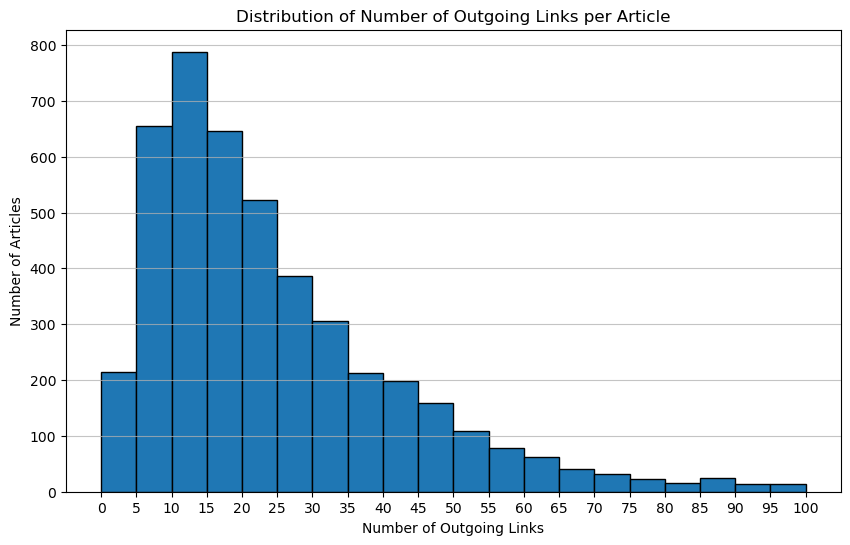

In [215]:
outgoing_link_counts = links.groupby('link_source').size()

# Creating the outgoing edges histogram
plt.figure(figsize=(10, 6))
plt.hist(outgoing_link_counts, bins= range(0, 101, 5), edgecolor='black')
plt.title('Distribution of Number of Outgoing Links per Article')
plt.xlabel('Number of Outgoing Links')
plt.ylabel('Number of Articles')
plt.xticks(bins)
plt.grid(axis='y', alpha=0.75)
plt.show()

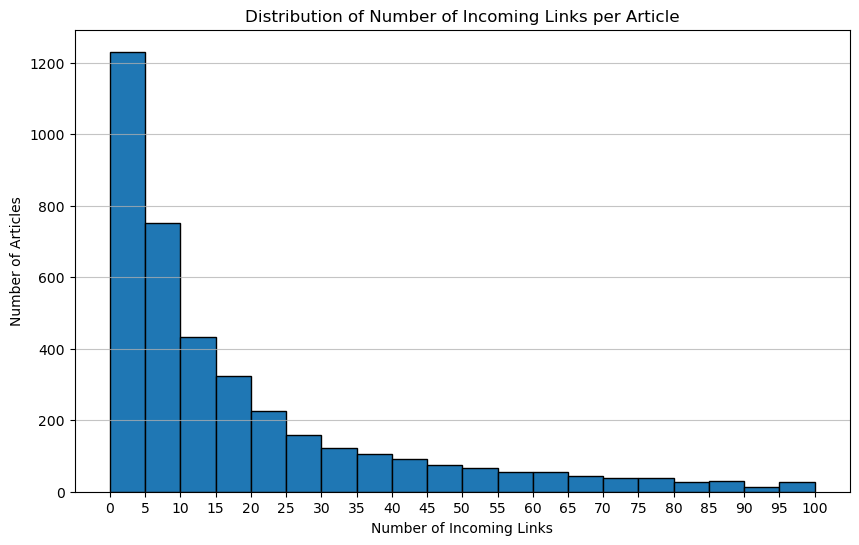

In [219]:
incoming_link_count = links.groupby('link_target').size()

# Creating the outgoing edges histogram
plt.figure(figsize=(10, 6))
plt.hist(incoming_link_count, bins= range(0, 101, 5), edgecolor='black')
plt.title('Distribution of Number of Incoming Links per Article')
plt.xlabel('Number of Incoming Links')
plt.ylabel('Number of Articles')
plt.xticks(bins)
plt.grid(axis='y', alpha=0.75)
plt.show()

We clearly see the unbalance between the two types of links, suggesting the existence of a category of articles wehre the flow of links (either in or out) is much more important than the others. 

In order to explore how the users use this netwok characteristic in the making of their game strategy, we need to find a metric to measure an article's importance in this topology : The Page Rank Algorithm

 ### 2) Page Rank Algorithm

We begin by constructing a directed graph of articles using the source and target in the links dataframe. We then use it to run the page rank algorithm.

In [8]:
# Verify that there is no missing source/target in links
links.any().isna()

link_source    False
link_target    False
dtype: bool

In [9]:
articles_graph = nx.from_pandas_edgelist(links, 'link_source', 'link_target', create_using=nx.DiGraph())

In [10]:
#see if there are danglimg nodes
dangling_nodes = []
for node, out_deg in articles_graph.out_degree():
    if out_deg == 0:
        dangling_nodes.append(node)
        
dangling_nodes

['Osteomalacia',
 'Local_community',
 'Directdebit',
 'Duchenne_muscular_dystrophy',
 'Klinefelter%27s_syndrome']

In [11]:
# Running page rank algorithm to detect hubs
page_rank = nx.pagerank(articles_graph, alpha = 0.95)

In [12]:
keys = list(page_rank.keys())
vals = list(page_rank.values())

# Sorted_page_rank is a dict that contains the rank of each article
sorted_page_rank = {keys[i]: vals[i] for i in np.argsort(vals)[::-1]}


sorted_keys = list(sorted_page_rank.keys())
sorted_vals = list(sorted_page_rank.values())

# Top_articles contains the articles with largest rank
top_articles = []

print('The top 20 articles in terms of page rank are:')
for i in range(20):
    top_articles.append(sorted_keys[i])
    print(sorted_keys[i], ' : ', sorted_vals[i])
    

The top 20 articles in terms of page rank are:
United_States  :  0.009935032746117654
France  :  0.007229330714372333
Europe  :  0.0070304734690667175
United_Kingdom  :  0.00678777228452997
English_language  :  0.005449952687638059
Germany  :  0.005431830090461531
World_War_II  :  0.0051700876243443335
Latin  :  0.004939355069146878
India  :  0.0046305652074681665
England  :  0.004594809997467629
Japan  :  0.004294950215222161
Italy  :  0.004210976559873735
Time_zone  :  0.004194672678432141
Spain  :  0.004176952026957267
China  :  0.004051336363203921
Currency  :  0.004004790498849306
Russia  :  0.003989833476264975
Canada  :  0.003623844391861864
Christianity  :  0.0035685560331047794
List_of_countries_by_system_of_government  :  0.003525842378425106


Now that we finished the page rank algorithm 

### We would like to consider the paths ....

We seperate each path into UpPath (from starting article to the hub) and DownPath (from the hub to the endpoint).

For that we first need to process the paths by taking into consideration the back cliks.

In [13]:
display(finished_paths)

,hashedIpAddress,timestamp,durationInSec,path,rating
0,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
1,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
2,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
3,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0
4,5295bca242be81fe,1372890414,110,14th_century;Europe;North_America;United_State...,NaN
...,...,...,...,...,...
51312,15a13a1d66ef5456,1349231015,66,Yagan;Ancient_Egypt;Civilization,NaN
51313,2ef7ac844cefda58,1300254138,165,Yagan;Folklore;Brothers_Grimm;<;19th_century;C...,3.0
51314,12863abb7887f890,1385095372,228,Yagan;Australia;England;France;United_States;T...,NaN
51315,19f8284371753362,1298792567,56,Yarralumla%2C_Australian_Capital_Territory;Aus...,1.0


In [14]:
display(unfinished_paths)

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout
...,...,...,...,...,...,...
24870,109ed71f571d86e9,1389787605,180,Franz_Kafka;Tuberculosis;World_Health_Organiza...,Cholera,restart
24871,232f992e57d43e8d,1389787697,6,Modern_history,Hollandic,restart
24872,2e09a7224600a7cd,1389798400,1900,Computer_programming;Linguistics;Culture;Popul...,The_Beatles,timeout
24873,60af9e2138051b96,1389799481,1903,Jamaica;United_Kingdom;World_War_II;Battle_of_...,Alan_Turing,timeout


In [15]:

# remove_unvisited_pages
def remove_unvisited_pages(path):
    if path.count('<') == 0:
        return path
    i=0
    while i<len(path):
        if path[i] == '<':
            counter = 0
            tmp_i = i
            while tmp_i<len(path) and path[tmp_i] == '<':
                tmp_i +=1
                counter+=1
            m=max(0,i-counter)

            for j in range(m, i):
                path[j] = '<'
            i = tmp_i
        else:
            i+=1
    indx = np.where(np.array(path)=='<')[0]
    path = np.delete(np.array(path), indx)
    return list(path)

In [16]:

def process_paths(paths,processed_paths,pages_with_no_rank,upPath = True) :
    for i, s in paths.iterrows():
        path_split=(paths['path'].iloc[i]).split(';')
        path_split = remove_unvisited_pages(path_split)
        ranks = []
        for elem in path_split:
            r = page_rank.get(elem, -1)
            if r==-1:
                pages_with_no_rank.append(elem)
            ranks.append(r)
        if upPath : 
            processed_paths.append(path_split[:np.argmax(ranks)])
        else : 
            processed_paths.append(path_split[np.argmax(ranks) :])


In [17]:
# paths_rank_ : a list of lists that containsall the paths padded with 0 at the end so that they have he same length
paths_rank_=[]

m=407

for i, s in finished_paths.iterrows():
    path_split = (finished_paths['path'].iloc[i]).split(';')

    path_split = remove_unvisited_pages(path_split)

    for j in range(len(path_split)):
        path_split[j] = page_rank.get(path_split[j], -1)

        
    if (len(path_split) < m):
        tmp = [0]*(m-len(path_split))

        e = path_split+tmp
        path_split  =e
        
    paths_rank_.append(path_split)

In [18]:
# paths_rank_df is dataframe that contains all finished paths where each article is represented by its page rank
paths_rank_df = pd.DataFrame(paths_rank_)


In [19]:
counter_path_length = paths_rank_df.apply(lambda x: (x!=0).sum(),axis=1)
frequencies_length = counter_path_length.value_counts()



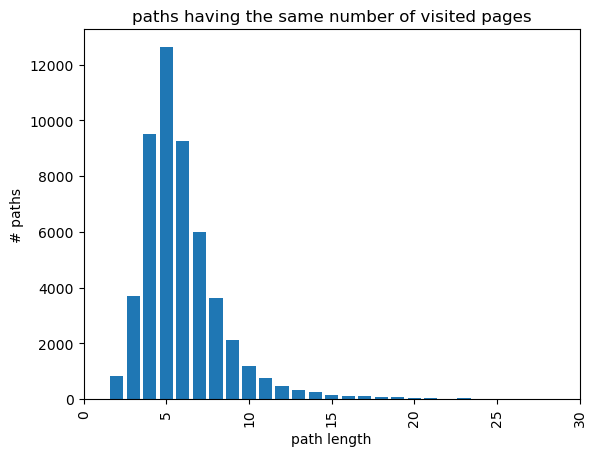

In [20]:
# plot the number of paths having the same number of visited pages
plt.bar(frequencies_length.index,frequencies_length.values)
plt.xticks(rotation=90)
plt.title('paths having the same number of visited pages')
plt.ylabel('# paths')
plt.xlabel('path length')
plt.xlim(0,30)
plt.show()

In [21]:
np.median(frequencies_length.values)

9.0

In [22]:
paths_rank_df['length']= counter_path_length

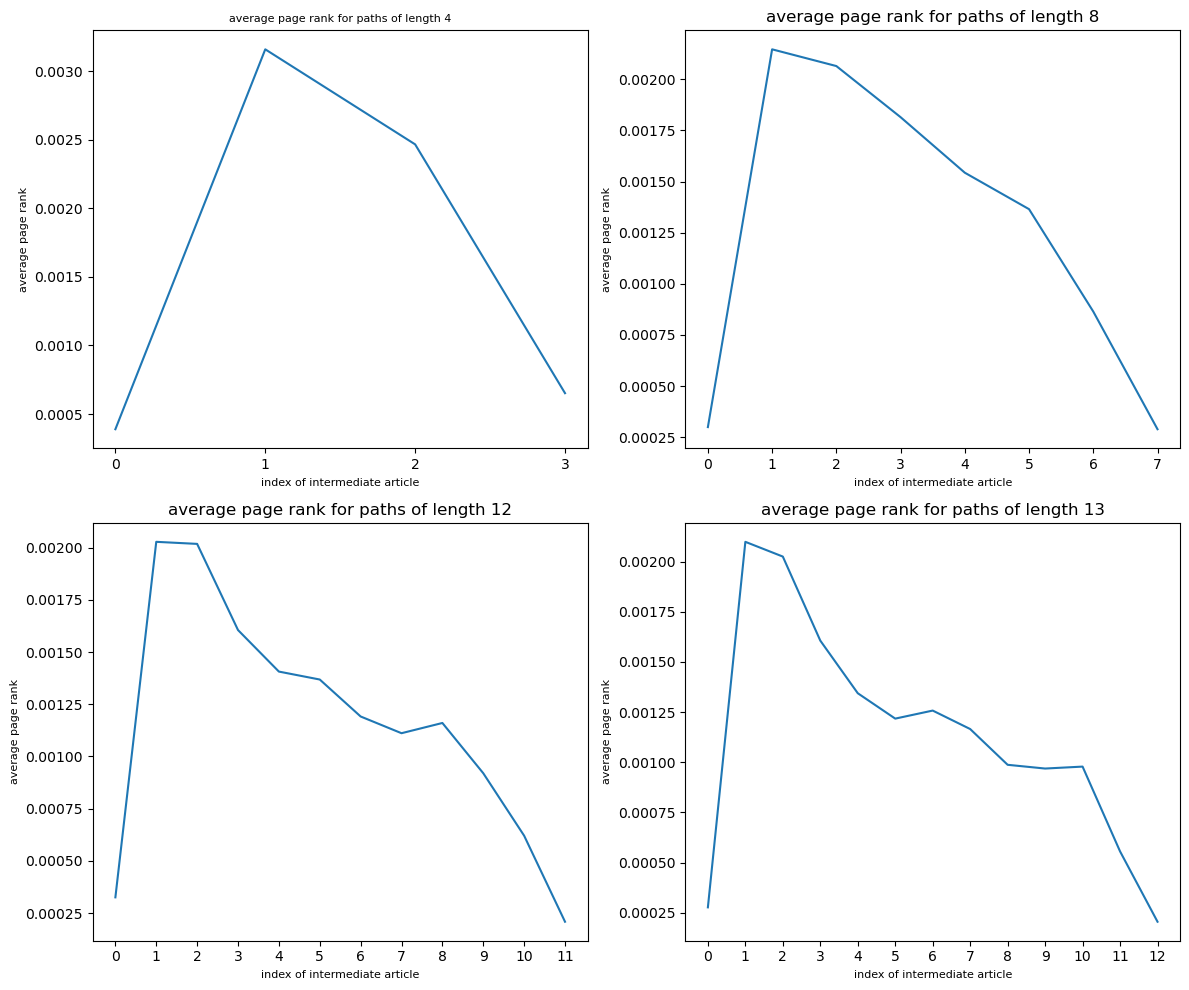

In [23]:
fig, axs = plt.subplots(2,2, figsize=(12,10))

len_ = 4
paths_fixed_len = paths_rank_df.copy()[paths_rank_df['length']==len_]
columns_to_drop = paths_fixed_len.columns[len_:]
new_paths_fixed_len = paths_fixed_len.drop(columns_to_drop, axis = 1)
x = new_paths_fixed_len.mean(axis=0)
x_vals = np.arange(len(x))
axs[0,0].plot(x.values)
axs[0,0].set_xticks(x_vals)
axs[0,0].set_xlabel('index of intermediate article', fontsize=8)
axs[0,0].set_title('average page rank for paths of length %d'%len_, fontsize=8)
axs[0,0].set_ylabel('average page rank', fontsize=8)



len_ = 8
paths_fixed_len = paths_rank_df.copy()[paths_rank_df['length']==len_]
columns_to_drop = paths_fixed_len.columns[len_:]
new_paths_fixed_len = paths_fixed_len.drop(columns_to_drop, axis = 1)
x = new_paths_fixed_len.mean(axis=0)
axs[0,1].set_xlabel('index of intermediate article', fontsize=8)
axs[0,1].plot(x.values)
x_vals = np.arange(len(x))
axs[0,1].set_xticks(x_vals)
axs[0,1].set_title('average page rank for paths of length %d'%len_)
axs[0,1].set_ylabel('average page rank',  fontsize=8)



len_ = 12
paths_fixed_len = paths_rank_df.copy()[paths_rank_df['length']==len_]
columns_to_drop = paths_fixed_len.columns[len_:]
new_paths_fixed_len = paths_fixed_len.drop(columns_to_drop, axis = 1)
x = new_paths_fixed_len.mean(axis=0)
axs[1,0].plot(x.values)
axs[1,0].set_title('average page rank for paths of length %d'%len_)
axs[1,0].set_ylabel('average page rank',  fontsize=8)
axs[1,0].set_xlabel('index of intermediate article', fontsize=8)

x_vals = np.arange(len(x))
axs[1,0].set_xticks(x_vals)



len_ = 13
paths_fixed_len = paths_rank_df.copy()[paths_rank_df['length']==len_]
columns_to_drop = paths_fixed_len.columns[len_:]
new_paths_fixed_len = paths_fixed_len.drop(columns_to_drop, axis = 1)
x = new_paths_fixed_len.mean(axis=0)
axs[1,1].plot(x.values)
axs[1,1].set_xlabel('index of intermediate article', fontsize=8)
axs[1,1].set_ylabel('average page rank', fontsize=8)
x_vals = np.arange(len(x))
axs[1,1].set_xticks(x_vals)
axs[1,1].set_title('average page rank for paths of length %d'%len_)

fig.tight_layout()
plt.show()


In [24]:
# processed paths contains all the paths starting from the 'hub'  or up to the 'hub' depending if it is upPath or downPath

In [25]:
processed_finished_paths_upPath = []
pages_with_no_rank_finished_paths_upPath = []  # those pages are missing in 'articles' ?! Should we add them to the graph ?
process_paths(finished_paths,processed_finished_paths_upPath,pages_with_no_rank_finished_paths_upPath)  

processed_finished_paths_downPath = []
pages_with_no_rank_finished_paths_downPath = []  # those pages are missing in 'articles' ?! Should we add them to the graph ?
process_paths(finished_paths,processed_finished_paths_downPath,pages_with_no_rank_finished_paths_downPath, upPath=False)  


In [26]:
processed_unfinished_paths_upPath = []
pages_with_no_rank_unfinished_paths_upPath = []  # those pages are missing in 'articles' ?! Should we add them to the graph ?
process_paths(unfinished_paths,processed_unfinished_paths_upPath,pages_with_no_rank_unfinished_paths_upPath)  

processed_unfinished_paths_downPath = []
pages_with_no_rank_unfinished_paths_downPath = []  # those pages are missing in 'articles' ?! Should we add them to the graph ?
process_paths(unfinished_paths,processed_unfinished_paths_downPath,pages_with_no_rank_unfinished_paths_downPath, upPath=False)  

###### Now we would like to consider the categories ....

In [27]:
categories.head()

,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_...
4,%C3%89douard_Manet,subject.People.Artists


129  different categories


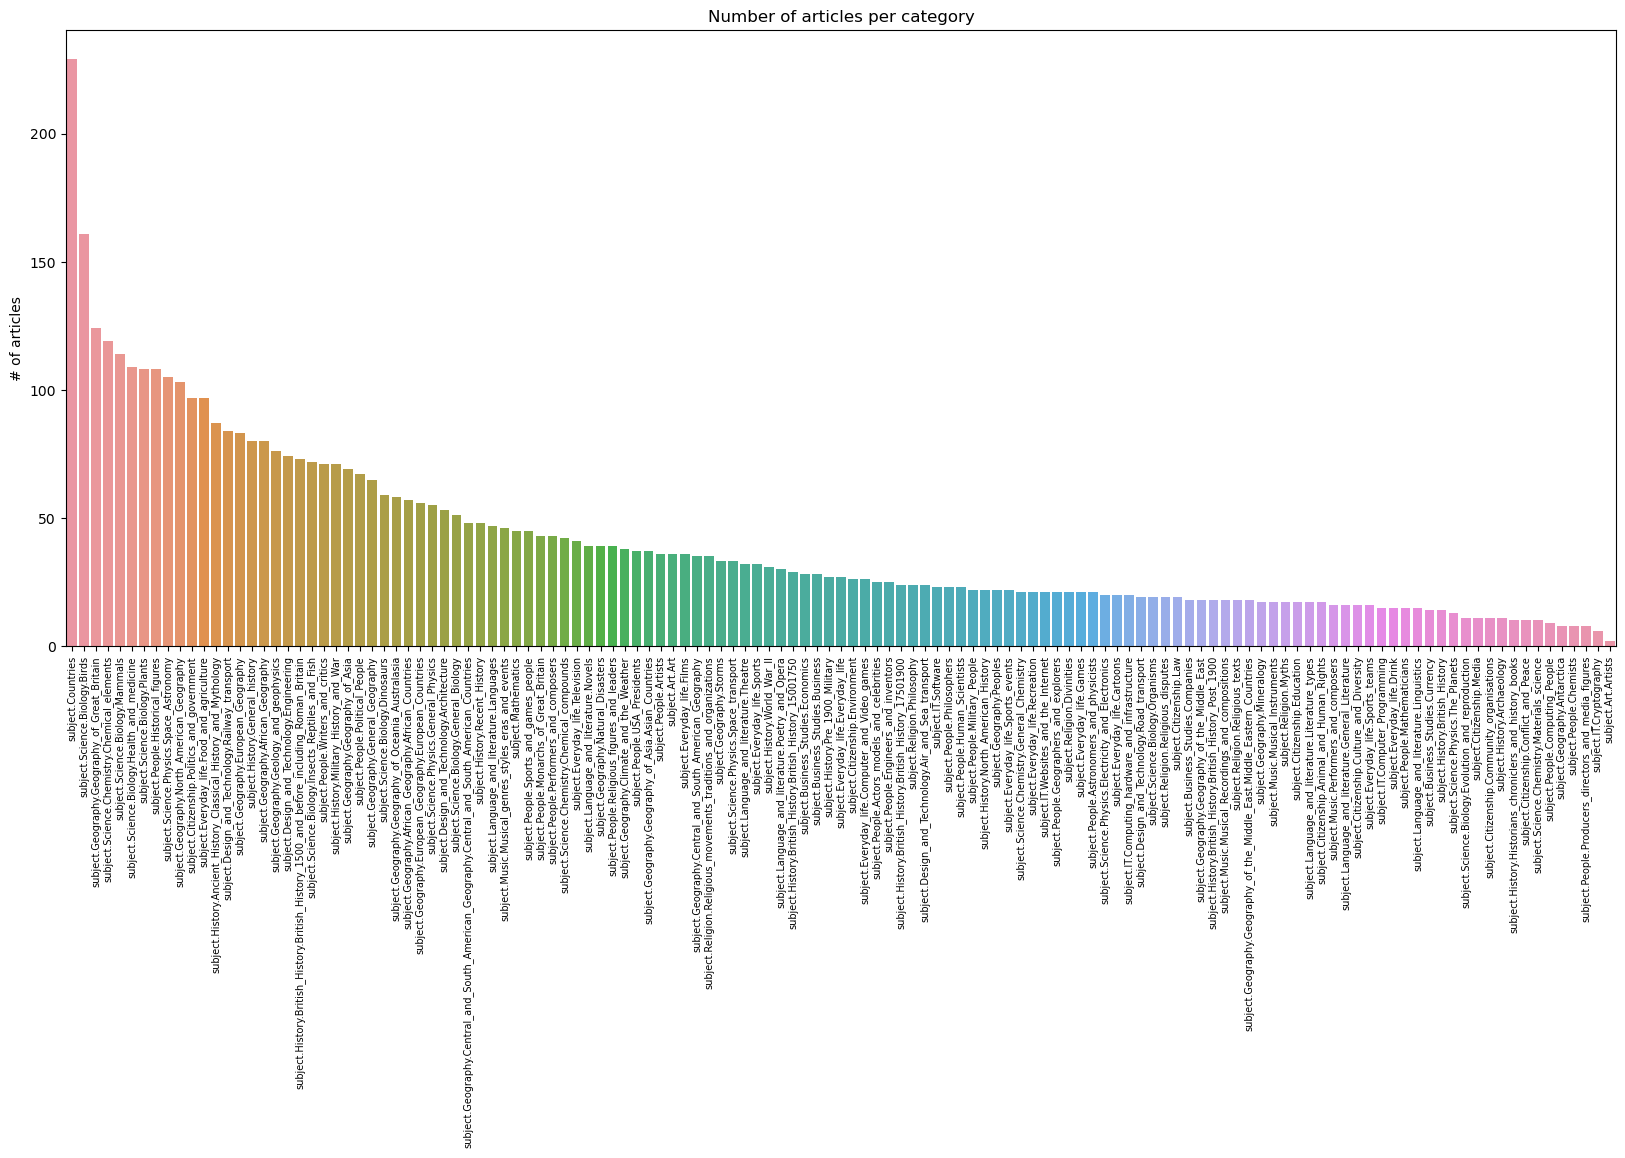

In [28]:
unique_categories = categories['category'].drop_duplicates()
print(len(unique_categories), ' different categories')

freq = categories['category'].value_counts()

plt.figure(figsize=(20, 8))
sns.barplot(x=freq.index, y=freq.values, width = 0.8)
plt.xticks(rotation=90, fontsize=7)
plt.title('Number of articles per category')
plt.ylabel('# of articles')
plt.show()

In [29]:
# The number of periods is the specifity of the category, the more specific 
# the more relevant 
def count_periods(s):
    return s.count('.')

In [30]:
# Column with the count of periods in the category
categories['period_count'] = categories['category'].apply(count_periods)

# Most specific category for each article
most_specific_category = categories.sort_values(by='period_count', ascending=False).drop_duplicates('article')
specific_categories = most_specific_category.drop(columns=['period_count'])

# Reseting the index
specific_categories.reset_index(drop=True, inplace=True)

specific_categories.head()

,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,European_Greenfinch,subject.Science.Biology.Birds
2,Rutherfordium,subject.Science.Chemistry.Chemical_elements
3,Eurasian_Oystercatcher,subject.Science.Biology.Birds
4,Eurasian_Jay,subject.Science.Biology.Birds


In [31]:
# Making the article column the index
specific_categories = specific_categories.set_index('article')

In [32]:
specific_categories.head()


,category
article,
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
European_Greenfinch,subject.Science.Biology.Birds
Rutherfordium,subject.Science.Chemistry.Chemical_elements
Eurasian_Oystercatcher,subject.Science.Biology.Birds
Eurasian_Jay,subject.Science.Biology.Birds


In [33]:
# printing the categories of the top articles 
categories_of_top_articles = []
for a in top_articles:
    print('categories of ', a)
    c = categories[categories['article']==a]['category'].tolist()
    categories_of_top_articles+=c
    print(c)
    print()

categories of  United_States
['subject.Countries', 'subject.Geography.North_American_Geography']

categories of  France
['subject.Countries', 'subject.Geography.European_Geography.European_Countries']

categories of  Europe
['subject.Geography.European_Geography']

categories of  United_Kingdom
['subject.Countries', 'subject.Geography.European_Geography.European_Countries', 'subject.Geography.Geography_of_Great_Britain']

categories of  English_language
['subject.Language_and_literature.Languages']

categories of  Germany
['subject.Countries', 'subject.Geography.European_Geography.European_Countries']

categories of  World_War_II
['subject.History.British_History.British_History_Post_1900']

categories of  Latin
['subject.Language_and_literature.Languages']

categories of  India
['subject.Geography.Geography_of_Asia.Asian_Countries', 'subject.Countries']

categories of  England
['subject.Geography.Geography_of_Great_Britain']

categories of  Japan
['subject.Geography.Geography_of_Asia.

In [34]:
from collections import Counter
x=list(Counter(categories_of_top_articles).keys())
y=list(Counter(categories_of_top_articles).values())


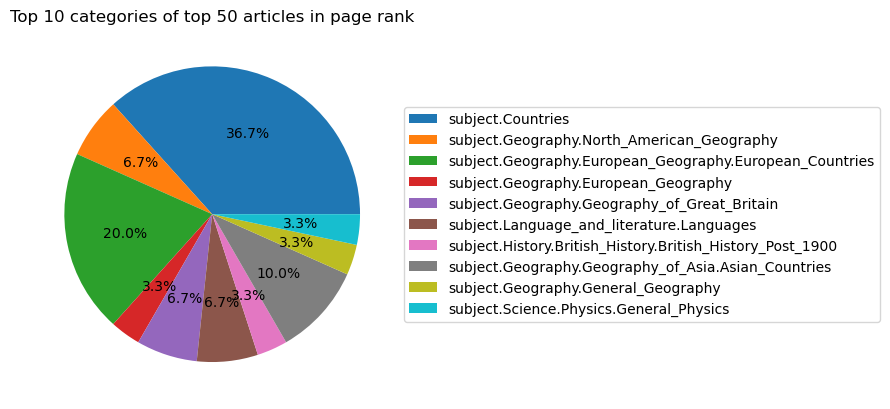

In [35]:

plt.pie(y[:10], autopct='%1.1f%%')
plt.title('Top 10 categories of top 50 articles in page rank')
plt.legend( labels=x[:10],loc='center left', bbox_to_anchor=(1,0.5))
plt.show()

We observe that top ranked articles have categories mainly_ Countries, geography, history, science. This suggest that will have high traffic through those categories. Also we expect the hubs to be mostly part of those categories.

### 2 - Analyse finished Paths Behavior
## ************************************************************************************************************************

### 2-1 Finished Paths - UpPath

In this part , we will  be directed towards the "Up Paths" segment of the succesfully finished paths. Specifically, we will utilize all the transitions leading up to the hub (estimated as the article with  the maximum page rank score) for each path. This information was previously calculated in the preceding section. Our objective here is to confirm whether the trend within this initial portion of the transitions involves links from a specific category to a more general one, in order to attain some hub.

In [36]:
# building the connection dataframe with the counter
def build_category_connections(category_paths) :
    category_pairs_counter = defaultdict(int)

    # Process each path
    for path in category_paths:
        for i in range(len(path) - 1):
            # Increment the counter for each found pair
            pair = (path[i], path[i + 1])
            category_pairs_counter[pair] += 1

    # unique category list that appear in our paths, 
    # no need for all categories of articles in  
    unique_categories = []
    for path in category_paths : 
        for cat in path : 
            if cat not in unique_categories : 
                unique_categories.append(cat)


    # Initialize an the connections
    category_connections = pd.DataFrame(index=unique_categories, columns=unique_categories).fillna(0)

    # filling up the values with the counts
    for (cat1, cat2), count in category_pairs_counter.items():
        category_connections.loc[cat1, cat2] = count
    
    return category_connections

In [37]:
def count_words(index):
    return len(index.split('.'))

In [38]:
def heatmap_general_categories(category_connections) :
    df = category_connections.copy() 
    df = df.drop(index = "Unknown_Category")
    df = df.drop(columns = "Unknown_Category")
    df = df.fillna(0)
    #Remove 'subject.' prefix since it is common to all categories
    prev_list = [ li  for li in df.columns]
    
    unique_vals = list(set(stri.split('.')[1] for stri in df.index))
    print(unique_vals)
    final_df = pd.DataFrame(index = unique_vals, columns = unique_vals)
    final_df = final_df.fillna(0)
    

    for ind1,row1 in df.iterrows() :
        for value in prev_list :
            final_df.loc[ind1.split('.')[1],value.split('.')[1]] =  final_df.loc[ind1.split('.')[1],value.split('.')[1]] + row1[value]
    # Replacing diagonal elements with 0
    rows, cols = final_df.shape
    for i in range(rows):
        final_df.iloc[i, i] = 0        
    

    final_df = final_df.div(final_df.sum(axis=1), axis=0)    
    #plotting the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(final_df, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True)
    plt.title('Heatmap of Weights between Categories')
    plt.show()   
    return final_df

In [39]:
#Now we can also focus only on categories that belong to a  General Category such as Science or History... 
def heatMap_Special_Category(category,category_connections) : 
    
    df = category_connections.copy() 
    
    #Remove 'subject.' prefix again
    df.index = df.index.str.replace('subject.', '')
    df.columns = df.columns.str.replace('subject.', '')
    #filtering   all the categories to keep only those that belong to the general one
    df = df.filter(like=category, axis=1).filter(like=category, axis=0)
    
    #Again dropping all the diagonal values for the same reasons as before
    np.fill_diagonal(df.values, 0)
    df = df.div(df.sum(axis=1), axis=0)
    #Plotting the heatMap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True)
    plt.title('Heatmap of Weights between Categories of %s' %category)
    plt.show()   

In [40]:
from bokeh.io import output_notebook, show, save
output_notebook()
from bokeh.plotting import figure, from_networkx
from bokeh.transform import linear_cmap
from bokeh.palettes import Category20
import community  
from bokeh.models import ColorBar, HoverTool

def plot_interactive_graph_with_community_detection(matrix):
    
    #construct graph
    G_undirected = nx.from_pandas_adjacency(matrix)

    partition = community.best_partition(G_undirected)


    plot = figure(tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',title="Graph with Detected Communities")

    #generate graph renderer
    graph_renderer = from_networkx(G_undirected, nx.spring_layout(G_undirected), scale=1, center=(0, 0))


    #color nodes in the same community
    node_colors = [partition[node] for node in G_undirected.nodes()]
    graph_renderer.node_renderer.data_source.data['community'] = node_colors
    color_mapper = linear_cmap(field_name='community', palette=Category20[10], low=min(node_colors), high=max(node_colors))
    graph_renderer.node_renderer.glyph.update(fill_color=color_mapper)
    
    #add category name for each node
    category_names = [n for n in G_undirected.nodes()]
    graph_renderer.node_renderer.data_source.data['category_name'] = category_names

    #size proportional to degree
    node_degrees = dict(G_undirected.degree())
    coeff = 40/max(node_degrees.values())
    node_sizes = [node_degrees[node] *coeff for node in G_undirected.nodes()]
    graph_renderer.node_renderer.data_source.data['size'] = node_sizes
    graph_renderer.node_renderer.glyph.size = 'size'


    plot.renderers.append(graph_renderer)

    hover = HoverTool()
    hover.tooltips = [("Category_name", "@category_name"), ("Community", "@community")]
    plot.add_tools(hover)


    show(plot)
    
    
    
    return partition

Loading BokehJS ...

In [41]:
# transforming the article paths into paths of categories for the UpPath Part of the finished paths 
processed_finished_paths_serie = pd.Series(processed_finished_paths_upPath)
category_finished_paths_upPath = processed_finished_paths_serie.map(lambda path: [specific_categories.loc[article, 'category'] if article in specific_categories.index else 'Unknown_Category' for article in path])
category_finished_paths_upPath

0                        [subject.History.General_history]
1        [subject.History.General_history, subject.Geog...
2        [subject.History.General_history, subject.Hist...
3                        [subject.History.General_history]
4        [subject.History.General_history, subject.Geog...
                               ...                        
51312                  [subject.People.Historical_figures]
51313    [subject.People.Historical_figures, subject.Hi...
51314    [subject.People.Historical_figures, subject.Ge...
51315    [subject.Geography.Geography_of_Oceania_Austra...
51316                  [subject.People.Historical_figures]
Length: 51317, dtype: object

In [42]:
# build category connections for uppath categories 
category_connections_finished_paths_upPath = build_category_connections(category_finished_paths_upPath)
category_connections_finished_paths_upPath

subject.History.General_history  \
subject.History.General_history                                                 285   
subject.Geography.African_Geography.African_Cou...                               10   
subject.History.British_History                                                   9   
subject.Citizenship.Animal_and_Human_Rights                                       1   
subject.History.Ancient_History_Classical_Histo...                               56   
...                                                                             ...   
subject.Geography.Antarctica                                                      0   
subject.Religion.Religious_disputes                                               2   
subject.People.Actors_models_and_celebrities                                      0   
subject.History.Historians_chroniclers_and_hist...                                1   
Unknown_Category                                                                  0   

                                                    subject.Geography.African_Geography.African_Countries  \
subject.History.General_history                                                                    15       
subject.Geography.African_Geography.African_Cou...                                                 85       
subject.History.British_History                                                                     5       
subject.Citizenship.Animal_and_Human_Rights                                                         1       
subject.History.Ancient_History_Classical_Histo...                                                 42       
...                                                                                               ...       
subject.Geography.Antarctica                                                                        2       
subject.Religion.Religious_disputes                                                                 0       
subject.People.Actors_models_and_celebrities                                                        0       
subject.History.Historians_chroniclers_and_hist...                                                  0       
Unknown_Category                                                                                    0       

                                                    subject.History.British_History  \
subject.History.General_history                                                  23   
subject.Geography.African_Geography.African_Cou...                                5   
subject.History.British_History                                                  12   
subject.Citizenship.Animal_and_Human_Rights                                       0   
subject.History.Ancient_History_Classical_Histo...                               21   
...                                                                             ...   
subject.Geography.Antarctica                                                      0   
subject.Religion.Religious_disputes                                               0   
subject.People.Actors_models_and_celebrities                                      1   
subject.History.Historians_chroniclers_and_hist...                                3   
Unknown_Category                                                                  0   

                                                    subject.Citizenship.Animal_and_Human_Rights  \
subject.History.General_history                                                               1   
subject.Geography.African_Geography.African_Cou...                                            2   
subject.History.British_History                                                               3   
subject.Citizenship.Animal_and_Human_Rights                                                  36   
subject.History.Ancient_History_Classical_Histo...                                            5   
...                                                        

['Mathematics', 'History', 'IT', 'Language_and_literature', 'Religion', 'Business_Studies', 'Music', 'Citizenship', 'Geography', 'Art', 'Design_and_Technology', 'Everyday_life', 'People', 'Science']


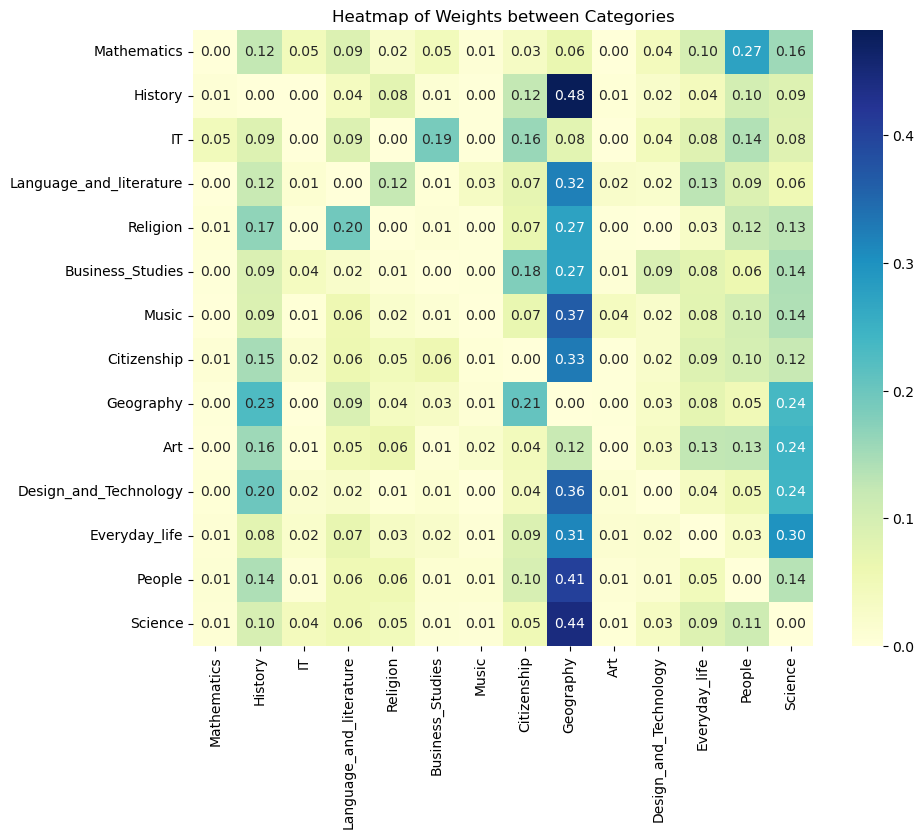

,Mathematics,History,IT,Language_and_literature,Religion,Business_Studies,Music,Citizenship,Geography,Art,Design_and_Technology,Everyday_life,People,Science
Mathematics,0.000000,0.124248,0.046092,0.088176,0.024048,0.046092,0.006012,0.032064,0.064128,0.000000,0.042084,0.096192,0.274549,0.156313
History,0.005799,0.000000,0.001740,0.038562,0.075964,0.011018,0.002030,0.122644,0.482749,0.005219,0.023485,0.043201,0.102349,0.085242
IT,0.046138,0.086259,0.000000,0.087262,0.001003,0.187563,0.003009,0.159478,0.078235,0.000000,0.044132,0.083250,0.139418,0.084253
Language_and_literature,0.000511,0.117527,0.012264,0.000000,0.121104,0.005621,0.032192,0.072560,0.321921,0.024016,0.019417,0.129790,0.087890,0.055187
Religion,0.005132,0.166422,0.002933,0.195015,0.000000,0.005865,0.002933,0.067449,0.274194,0.003666,0.001466,0.027126,0.119501,0.128299
Business_Studies,0.002954,0.091581,0.038405,0.023634,0.008863,0.000000,0.002954,0.180207,0.273264,0.005908,0.093058,0.076809,0.060561,0.141802
Music,0.001792,0.089606,0.005376,0.057348,0.019713,0.010753,0.000000,0.066308,0.365591,0.039427,0.023297,0.078853,0.102151,0.139785
Citizenship,0.008673,0.148309,0.018647,0.059410,0.045533,0.056808,0.005204,0.000000,0.328274,0.002602,0.022984,0.085429,0.098439,0.119688
Geography,0.002205,0.229836,0.000551,0.092780,0.036377,0.031233,0.008451,0.205585,0.000000,0.002388,0.027375,0.075142,0.051258,0.236818
Art,0.000000,0.156410,0.005128,0.053846,0.064103,0.007692,0.020513,0.043590,0.117949,0.000000,0.033333,0.125641,0.128205,0.243590


In [43]:
heatmap_general_categories(category_connections_finished_paths_upPath)

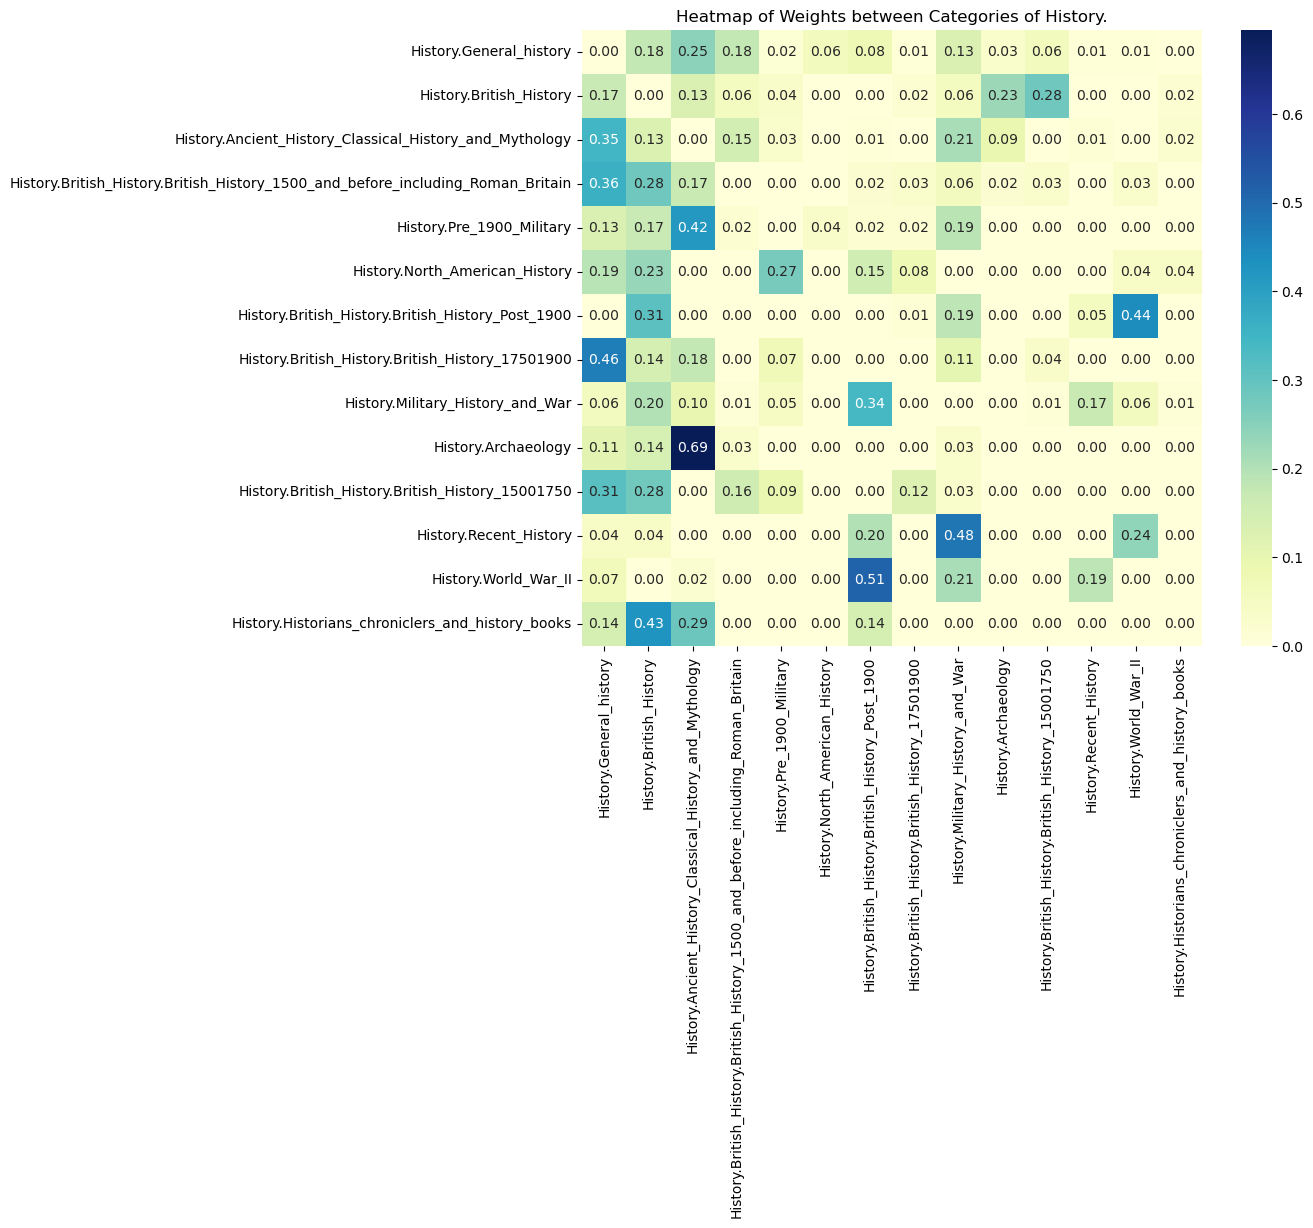

In [44]:
heatMap_Special_Category("History.",category_connections_finished_paths_upPath)

Let's consider the graph of detected communities for the uppath of finished paths

In [45]:

#partition = plot_interactive_graph_with_community_detection(category_connections_finished_paths_upPath)


In [46]:
def articles_per_partition(partition):
    partition_nodes = {}
    for node, part_id in partition.items():
        if part_id not in partition_nodes:
            partition_nodes[part_id] = []
        partition_nodes[part_id].append(node)

    # Print nodes in each partition
    for part_id, nodes in partition_nodes.items():
        print("Partition", part_id, ":")
        for n in nodes:
            print(n)
        print()


#articles_per_partition(partition)

In [47]:
# NEED TO DISCUSS
# Should we consider the partitions? for example show that usually 
# if it is logic to go from category A to B, thos categories will be in the same community ??

### 2-2 Finished Paths - DownPath

In this part , we will  focus on the "Down Paths" segment of the succesfully finished paths. Specifically, we will utilize all the transitions starting from the hub up to the final destination.Since we disovered in the previous sub-section that the first 'Up Path' segment lead to a general category in general(corresponding to the category of the hub), we will be expecting to find that the Down Path(i.e the second part of the transitions) generally involves links from  general category to a specific one.

In [48]:
# transforming the article paths into paths of categories for the downPath Part of the finished paths 
processed_finished_paths_serie_downPath = pd.Series(processed_finished_paths_downPath)
category_finished_paths_downPath = processed_finished_paths_serie_downPath.map(lambda path: [specific_categories.loc[article, 'category'] if article in specific_categories.index else 'Unknown_Category' for article in path])
print(category_finished_paths_downPath.head(1))

0    [subject.Geography.European_Geography, subject...
dtype: object


In [49]:
# build category connections 
category_connections_finished_paths_downPath = build_category_connections(category_finished_paths_downPath)
category_connections_finished_paths_downPath

subject.Geography.European_Geography  \
subject.Geography.European_Geography                                                 108   
subject.Geography.African_Geography                                                    1   
subject.History.British_History.British_History...                                     1   
subject.History.General_history                                                       41   
subject.Geography.European_Geography.European_C...                                  1173   
...                                                                                  ...   
subject.People.Actors_models_and_celebrities                                           0   
subject.People.Producers_directors_and_media_fi...                                     0   
subject.Music.Musical_Recordings_and_compositions                                      0   
subject.History.Historians_chroniclers_and_hist...                                     1   
Unknown_Category                                                                       0   

                                                    subject.Geography.African_Geography  \
subject.Geography.European_Geography                                                253   
subject.Geography.African_Geography                                                 509   
subject.History.British_History.British_History...                                    1   
subject.History.General_history                                                      14   
subject.Geography.European_Geography.European_C...                                   65   
...                                                                                 ...   
subject.People.Actors_models_and_celebrities                                          0   
subject.People.Producers_directors_and_media_fi...                                    0   
subject.Music.Musical_Recordings_and_compositions                                     0   
subject.History.Historians_chroniclers_and_hist...                                    1   
Unknown_Category                                                                      0   

                                                    subject.History.British_History.British_History_17501900  \
subject.Geography.European_Geography                                                                0          
subject.Geography.African_Geography                                                                44          
subject.History.British_History.British_History...                                                 23          
subject.History.General_history                                                                    11          
subject.Geography.European_Geography.European_C...                                                  2          
...                                                                                               ...          
subject.People.Actors_models_and_celebrities                                                        0          
subject.People.Producers_directors_and_media_fi...                                                  0          
subject.Music.Musical_Recordings_and_compositions                                                   0          
subject.History.Historians_chroniclers_and_hist...                                                  0          
Unknown_Category                                                                                    0          

                                                    subject.History.General_history  \
subject.Geography.European_Geography                                            219   
subject.Geography.African_Geography                                               2   
subject.History.British_History.British_History...                               23   
subject.History.General_history                                                1134   
subject.Geography.European_Geography.European_C...                        

['Mathematics', 'History', 'IT', 'Language_and_literature', 'Religion', 'Business_Studies', 'Music', 'Geography', 'Citizenship', 'Art', 'Design_and_Technology', 'Everyday_life', 'People', 'Science']


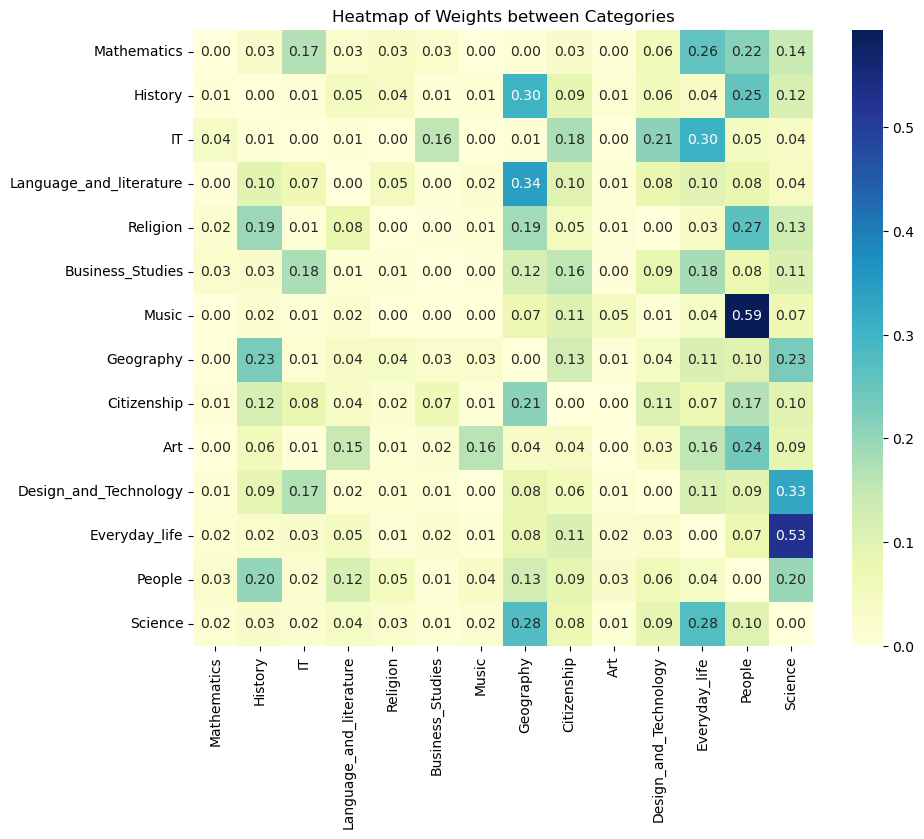

,Mathematics,History,IT,Language_and_literature,Religion,Business_Studies,Music,Geography,Citizenship,Art,Design_and_Technology,Everyday_life,People,Science
Mathematics,0.000000,0.029340,0.168704,0.026895,0.034230,0.026895,0.000000,0.004890,0.029340,0.004890,0.056235,0.259169,0.215159,0.144254
History,0.006509,0.000000,0.009002,0.050270,0.042930,0.006647,0.011633,0.302728,0.089738,0.014264,0.059687,0.035868,0.254674,0.116050
IT,0.040801,0.007418,0.000000,0.010386,0.000742,0.157270,0.000000,0.005193,0.178042,0.000000,0.209941,0.304896,0.048961,0.036350
Language_and_literature,0.003625,0.095468,0.067674,0.000000,0.049849,0.004834,0.020544,0.341390,0.103021,0.010574,0.079154,0.100604,0.080363,0.042900
Religion,0.021947,0.193702,0.007156,0.081584,0.000000,0.002863,0.010019,0.187500,0.050095,0.008588,0.001908,0.034828,0.265744,0.134065
Business_Studies,0.027051,0.028855,0.178539,0.012624,0.007214,0.000000,0.003607,0.123535,0.156898,0.003607,0.086564,0.183048,0.075744,0.112714
Music,0.001751,0.022767,0.008757,0.022767,0.000000,0.001751,0.000000,0.070053,0.108581,0.049037,0.012259,0.040280,0.593695,0.068301
Geography,0.001960,0.229090,0.014453,0.038399,0.041667,0.025830,0.026983,0.000000,0.128113,0.007073,0.041129,0.112469,0.104013,0.228821
Citizenship,0.008255,0.118143,0.080997,0.036629,0.022528,0.066896,0.007567,0.210146,0.000000,0.002064,0.108684,0.072743,0.167326,0.098022
Art,0.000000,0.059480,0.005576,0.146840,0.011152,0.020446,0.163569,0.035316,0.039033,0.000000,0.033457,0.156134,0.237918,0.091078


In [50]:
heatmap_general_categories(category_connections_finished_paths_downPath)

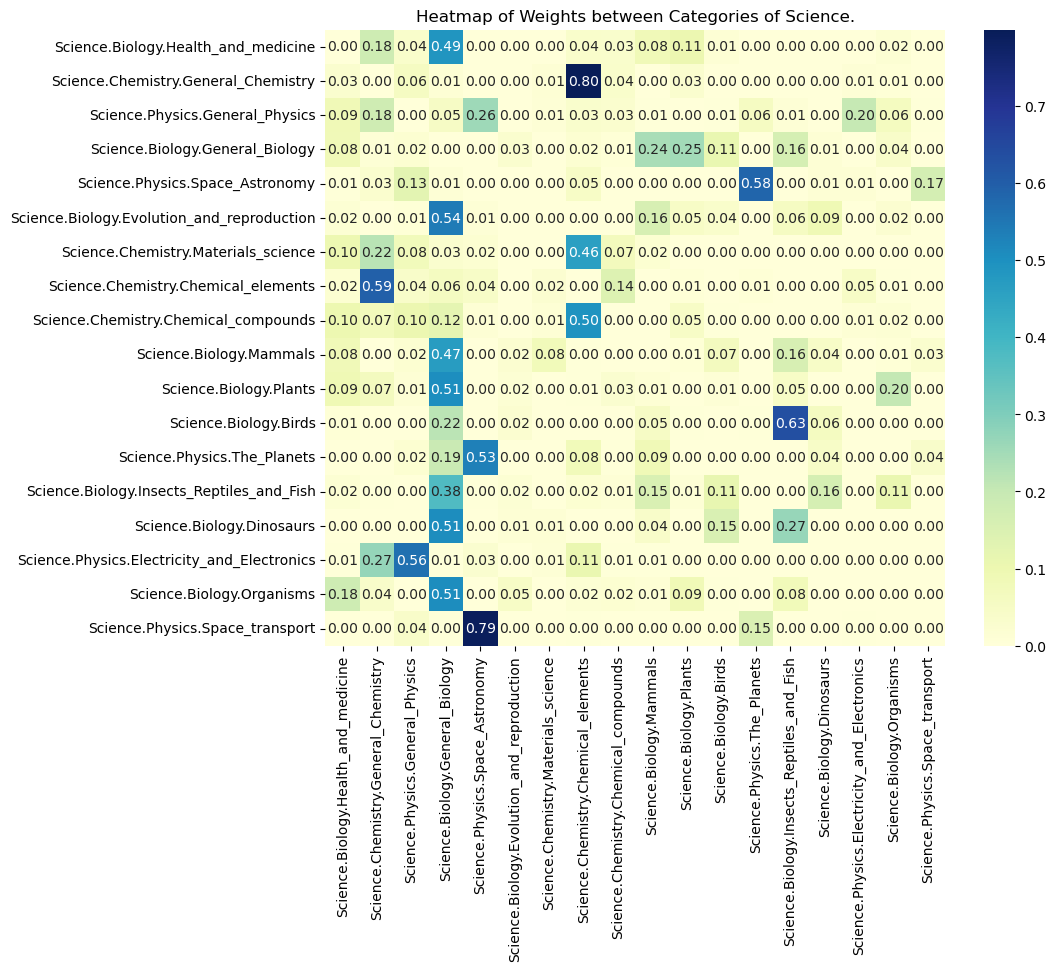

In [51]:
heatMap_Special_Category("Science.",category_connections_finished_paths_downPath)

In [52]:
#partition = plot_interactive_graph_with_community_detection(category_connections_finished_paths_downPath)

### 3 - Analyse Unfinished Paths Behavior
## ************************************************************************************************************************

### 3-1 Unfinished Paths - UpPath

In this sub-part, we conduct a similar analysis of the "UpPath" as we did previously for the completed paths, but this time focusing on the unfinished paths. This approach will allow us to  explore the important differences between successful and unsuccessful paths.

In [53]:
# transforming the article paths into paths of categories for the UpPath Part of the unfinished paths 
processed_unfinished_paths_serie = pd.Series(processed_unfinished_paths_upPath)   #check please
category_unfinished_paths_upPath = processed_unfinished_paths_serie.map(lambda path: [specific_categories.loc[article, 'category'] if article in specific_categories.index else 'Unknown_Category' for article in path])
category_unfinished_paths_upPath.head()

0                                                   []
1                                                   []
2    [subject.Geography.African_Geography.African_C...
3                                                   []
4    [subject.Geography.Central_and_South_American_...
dtype: object

In [54]:
#build category connections 
category_connections_unfinished_paths_upPath = build_category_connections(category_unfinished_paths_upPath)
category_connections_unfinished_paths_upPath

subject.Geography.African_Geography.African_Countries  \
subject.Geography.African_Geography.African_Cou...                                                 23       
subject.Geography.Central_and_South_American_Ge...                                                  2       
subject.Everyday_life.Food_and_agriculture                                                          1       
subject.History.British_History                                                                     1       
subject.Religion.Philosophy                                                                         0       
...                                                                                               ...       
subject.Design_and_Technology.Road_transport                                                        0       
subject.Everyday_life.Games                                                                         1       
subject.Geography.Central_and_South_American_Ge...                                                  0       
subject.IT.Software                                                                                 2       
subject.History.Historians_chroniclers_and_hist...                                                  1       

                                                    subject.Geography.Central_and_South_American_Geography.Central_and_South_American_Countries  \
subject.Geography.African_Geography.African_Cou...                                                  1                                             
subject.Geography.Central_and_South_American_Ge...                                                 25                                             
subject.Everyday_life.Food_and_agriculture                                                          3                                             
subject.History.British_History                                                                     1                                             
subject.Religion.Philosophy                                                                         1                                             
...                                                                                               ...                                             
subject.Design_and_Technology.Road_transport                                                        0                                             
subject.Everyday_life.Games                                                                         1                                             
subject.Geography.Central_and_South_American_Ge...                                                 20                                             
subject.IT.Software                                                                                 0                                             
subject.History.Historians_chroniclers_and_hist...                                                  0                                             

                                                    subject.Everyday_life.Food_and_agriculture  \
subject.Geography.African_Geography.African_Cou...                                           6   
subject.Geography.Central_and_South_American_Ge...                                           5   
subject.Everyday_life.Food_and_agriculture                                                  71   
subject.History.British_History                                                              0   
subject.Religion.Philosophy                                                                  0   
...                                                                                        ...   
subject.Design_and_Technology.Road_transport                                                 0   
subject.Everyday_life.Games                                                                  0   
subject.Geography.Central_and_South_American_Ge...                                           2  

['Mathematics', 'History', 'IT', 'Language_and_literature', 'Religion', 'Business_Studies', 'Music', 'Geography', 'Citizenship', 'Art', 'Design_and_Technology', 'Everyday_life', 'People', 'Science']


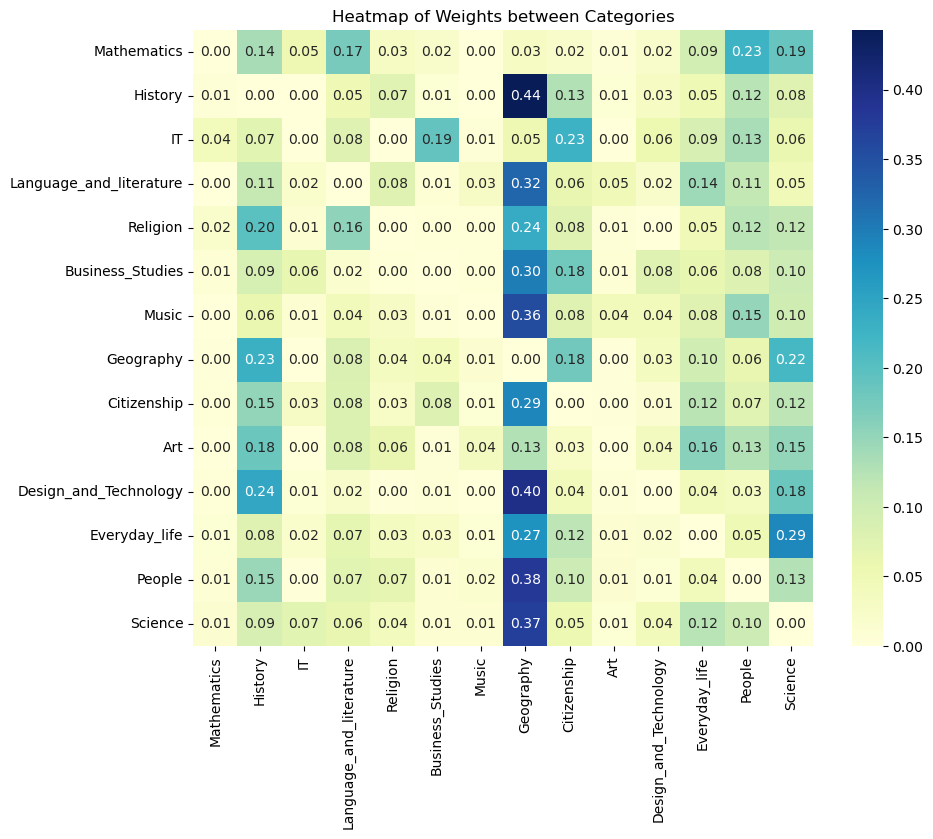

,Mathematics,History,IT,Language_and_literature,Religion,Business_Studies,Music,Geography,Citizenship,Art,Design_and_Technology,Everyday_life,People,Science
Mathematics,0.000000,0.136126,0.052356,0.172775,0.031414,0.020942,0.000000,0.031414,0.020942,0.005236,0.020942,0.094241,0.225131,0.188482
History,0.005477,0.000000,0.001565,0.050861,0.074335,0.009390,0.000782,0.442879,0.126761,0.010172,0.031299,0.048513,0.121283,0.076682
IT,0.040373,0.071429,0.000000,0.077640,0.000000,0.189441,0.006211,0.052795,0.226708,0.000000,0.055901,0.086957,0.133540,0.059006
Language_and_literature,0.001182,0.111111,0.017730,0.000000,0.076832,0.007092,0.028369,0.323877,0.063830,0.046099,0.021277,0.143026,0.113475,0.046099
Religion,0.019651,0.198690,0.010917,0.155022,0.000000,0.004367,0.004367,0.237991,0.076419,0.006550,0.000000,0.048035,0.122271,0.115721
Business_Studies,0.008547,0.089744,0.064103,0.017094,0.004274,0.000000,0.004274,0.299145,0.179487,0.008547,0.076923,0.064103,0.081197,0.102564
Music,0.000000,0.061111,0.011111,0.044444,0.027778,0.005556,0.000000,0.355556,0.077778,0.044444,0.044444,0.077778,0.150000,0.100000
Geography,0.002266,0.230630,0.001359,0.084730,0.035342,0.039873,0.012687,0.000000,0.176710,0.003172,0.034889,0.097870,0.062981,0.217490
Citizenship,0.004405,0.151982,0.028634,0.081498,0.027533,0.079295,0.009912,0.287445,0.000000,0.003304,0.012115,0.120044,0.074890,0.118943
Art,0.000000,0.183544,0.000000,0.082278,0.063291,0.006329,0.037975,0.126582,0.025316,0.000000,0.037975,0.158228,0.126582,0.151899


In [55]:
heatmap_general_categories(category_connections_unfinished_paths_upPath)

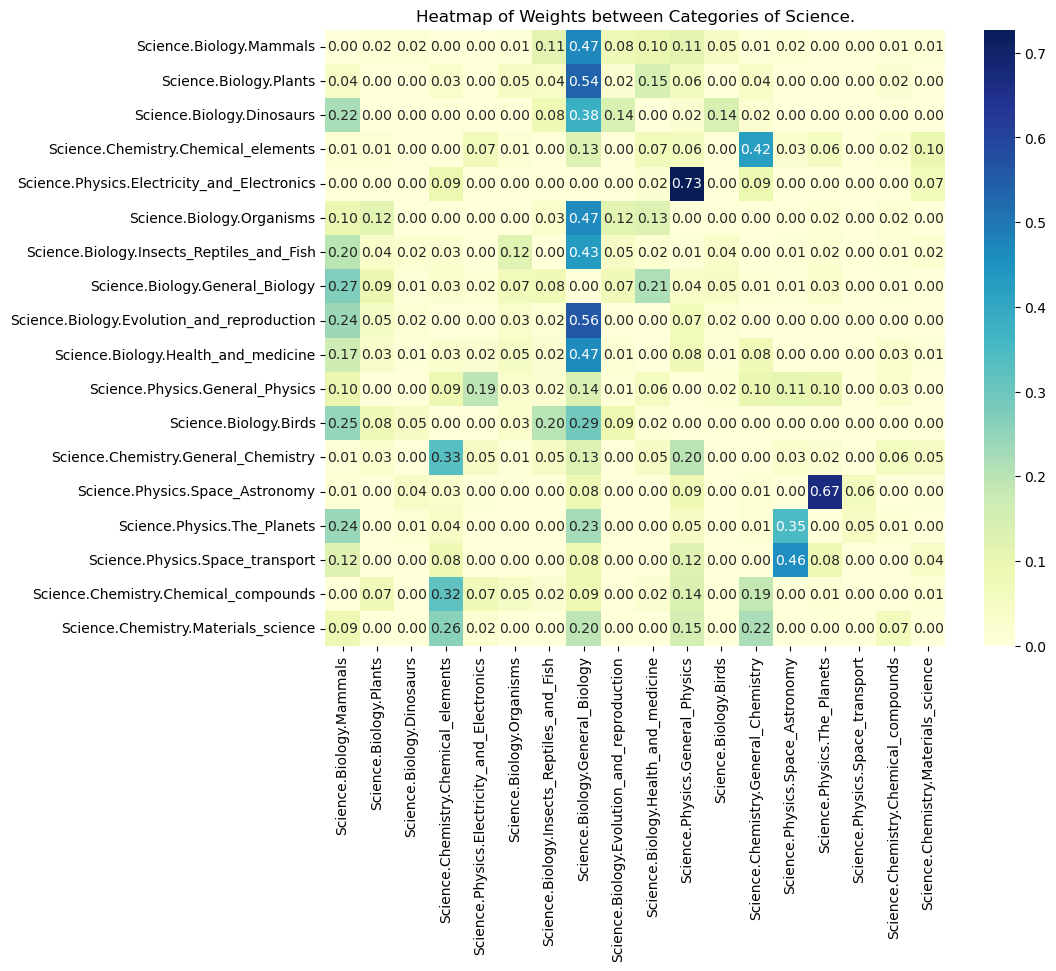

In [56]:
heatMap_Special_Category("Science.",category_connections_unfinished_paths_upPath)

### 3-2 Unfinished Paths - DownPath

In this subsection , We will conduct the same analysis for the DownPath of the  unfinished paths as we did for the finished paths. Given that we observed the same behavior in both paths for the UpPath segment during the previous subsection, we expect that the finished and unfinished paths both have the same behavior also for the DownPath, which means that we will observe links generally going from a general category to a more specific one.

In [57]:
# transforming the article paths into paths of categories  
processed_unfinished_paths_serie = pd.Series(processed_unfinished_paths_downPath)
category_unfinished_paths_downPath = processed_unfinished_paths_serie.map(lambda path: [specific_categories.loc[article, 'category'] if article in specific_categories.index else 'Unknown_Category' for article in path])
category_unfinished_paths_downPath.head()

0                        [subject.Everyday_life.Films]
1                  [subject.People.Historical_figures]
2    [subject.Citizenship.Politics_and_government, ...
3    [subject.Geography.Central_and_South_American_...
4    [subject.Geography.Central_and_South_American_...
dtype: object

In [58]:
#Build category connections
category_connections_unfinished_paths_downPath = build_category_connections(category_unfinished_paths_downPath)
category_connections_unfinished_paths_downPath

subject.Everyday_life.Films  \
subject.Everyday_life.Films                                                 107   
subject.People.Historical_figures                                             0   
subject.Citizenship.Politics_and_government                                   3   
subject.People.Military_People                                                0   
subject.Geography.Central_and_South_American_Ge...                            1   
...                                                                         ...   
subject.Everyday_life.Sports_teams                                            0   
subject.Everyday_life.Games                                                   0   
subject.Citizenship.Community_organisations                                   0   
subject.People.Chemists                                                       0   
subject.Religion.Religious_disputes                                           0   

                                                    subject.People.Historical_figures  \
subject.Everyday_life.Films                                                         0   
subject.People.Historical_figures                                                  10   
subject.Citizenship.Politics_and_government                                         4   
subject.People.Military_People                                                      0   
subject.Geography.Central_and_South_American_Ge...                                  1   
...                                                                               ...   
subject.Everyday_life.Sports_teams                                                  0   
subject.Everyday_life.Games                                                         0   
subject.Citizenship.Community_organisations                                         0   
subject.People.Chemists                                                             0   
subject.Religion.Religious_disputes                                                 0   

                                                    subject.Citizenship.Politics_and_government  \
subject.Everyday_life.Films                                                                   0   
subject.People.Historical_figures                                                             2   
subject.Citizenship.Politics_and_government                                                 310   
subject.People.Military_People                                                                0   
subject.Geography.Central_and_South_American_Ge...                                            4   
...                                                                                         ...   
subject.Everyday_life.Sports_teams                                                            0   
subject.Everyday_life.Games                                                                   0   
subject.Citizenship.Community_organisations                                                   5   
subject.People.Chemists                                                                       0   
subject.Religion.Religious_disputes                                                           0   

                                                    subject.People.Military_People  \
subject.Everyday_life.Films                                                      0   
subject.People.Historical_figures                                                1   
subject.Citizenship.Politics_and_government                                      2   
subject.People.Military_People                                                   0   
subject.Geography.Central_and_South_American_Ge...                               0   
...                                                                            ...   
subject.Everyday_life.Sports_teams                                               0   
subject.Everyday_life.Games                                                      0   
subject.Citizenship.Com

In [59]:
heatmap_general_categories(category_connections_unfinished_paths_downPath,UpPath=False)

TypeError: heatmap_general_categories() got an unexpected keyword argument 'UpPath'

In [ ]:
heatMap_Special_Category("Science.",category_connections_unfinished_paths_downPath)

### 4 - Compare destinations of finished and unfinished Paths
## ************************************************************************************************************************

In the previous part, we observed that both finished and unfinshed paths have exactly the same pattern : i.e  the first segment (UpPath) of the path

generaly escapes from specific categories to more general ones, up until  a hub, then the second segment(DownPath) links have tendency to go from general categories to more specific ones ,  this suggests that the difference between finished and unfinshed paths is not really the starting point , since we can reach a hub starting from anyhub, but the main difference might be in the final destination article, in this section we will try to analyse differences between the destinations of both finished and unfinished paths by comparing the distribution of their in-degrees.
    

In [ ]:
G = articles_graph
#we recover all the in-degrees of the destinations of the unfinished paths
unfinished_paths_in_degrees = unfinished_paths["target"].apply(lambda t: G.in_degree(t)).fillna(0).apply(lambda t : t if isinstance(t, (int)) else 0) + 1 
#we recover all the in-degrees of the destinations of the finished paths
finished_paths_in_degrees = finished_paths["path"].apply(lambda t : G.in_degree(t.split(";")[-1])).apply(lambda t : t if isinstance(t, (int)) else 0) +1


In [ ]:
# plotting the distributions of the in-degrees of destinations for both finished and unfinished_paths
ax = sns.histplot(finished_paths_in_degrees, kde=True, stat='density', color='orange', label='finished_paths',log_scale=True)
ax = sns.histplot(unfinished_paths_in_degrees, kde=True, stat='density', color='blue', label='unfinished_paths',log_scale=True)
plt.legend()
plt.ylabel("distribution")
plt.xlabel("in-degrees")
plt.show()

In this histogram, it is clear  that the destinations of unfinished paths are more likely to have lower in-degrees, indicating greater difficulty in reaching those destinations. Also, we can see that  starting from an in-degree of 20 degrees, the destinations of finished paths have a  higher probability. This observation aligns with intuition, as higher in-degrees suggest increased popularity of an article, making it more accessible and easier to reach.

## Fixing the no target importance in unsuccessful graphs  :

//TODO: Abdess write this better and place it where it should be  
BIG ANALYSIS PROBLEM : We analyze unsuccessful paths as if they were successful towards the "last trap", not taking the target into consideration at all (basically considering the last reached node as the target), since you're modeling how a user goes from one category to another, not taking the target into consideration will yield the exact same results. instead we add a negative weight in unsuccessful graphs denoting that the nodes in the downpath 

In [ ]:
def build_category_connections_unsuccessful(unfinished_paths_categories, targets_categories):
    category_pairs_counter = defaultdict(int)
    # Process each path
    for path_index, path in enumerate(unfinished_paths_categories):
        target_category = targets_categories[path_index]
        for i in range(len(path) - 1):
            # Increment the counter for each found pair
            pair = (path[i], path[i + 1])
            category_pairs_counter[pair] += 1
            # Decrement the counter between this pair and the end category 
            category_pairs_counter[(path[i], target_category)] -= 1

    # unique category list that appear in our paths, 
    # no need for all categories of articles  
    unique_categories = list(set(cat for path in unfinished_paths_categories for cat in path)| set(targets_categories))
    
    # Initialize an the connections
    category_connections = pd.DataFrame(index=unique_categories, columns=unique_categories).fillna(0)

    # filling up the values with the counts
    for (cat1, cat2), count in category_pairs_counter.items():
        category_connections.loc[cat1, cat2] = count
    
    return category_connections

//TODO ABDESS

I checked but I may be wrong : 
the target links are the same order as the initial links 


In [ ]:
# transforming the article paths into paths of categories  
unsuccessful_downpaths = pd.Series(processed_unfinished_paths_downPath)
category_unfinished_paths_downPath = processed_unfinished_paths_serie.map(lambda path: [specific_categories.loc[article, 'category'] if article in specific_categories.index else 'Unknown_Category' for article in path])
targets_categories = unfinished_paths["target"]
fixed_unfinished_connections = build_category_connections_unsuccessful(category_unfinished_paths_downPath, targets_categories)

//TODO : Discuss 
Note on execution The problem here is that we have too many columns, every target comes with his own obscure category, (nearly 30000 categories added impossible to visualize) this needs to be handled in some way :
- Alternative: just decrement the connection making the entries into a relevance score towards finding the objective and not simply a connection score  (simple 1 line change, decrement the connection for every connection we see since it wasn't able to bring us to the objective)

In [ ]:
# heatmap_general_categories(fixed_unfinished_connections , UpPath = False)

## Model for predicting the success of a  path : Page rank based model 

Intuition : if the logical behavior isn't what matters after all then we can determine the success of a path only based of the "importance" of the articles and how well connected they are in the wikipedia graph (page rank score), we also saw that the UP PATH doesn't matter as much for classifying the paths since both successful and unsuccessful paths have the same in the  => We focus our analyisis on the DOWN PATH


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler


In [ ]:
unique_ips = pd.concat([finished_paths["hashedIpAddress"],unfinished_paths["hashedIpAddress"]]).unique()
dicti = {key: 0 for key in unique_ips}
for indx,row in finished_paths.iterrows() :
    dicti[row["hashedIpAddress"]] +=1


In [ ]:
for indx,row in unfinished_paths.iterrows() :
    dicti[row["hashedIpAddress"]] +=1

In [ ]:
p1 = finished_paths["hashedIpAddress"].apply(lambda t : dicti[t] if t in dicti.keys() else 0)        
p1
p2 = unfinished_paths["hashedIpAddress"].apply(lambda t : dicti[t] if t in dicti.keys() else 0)        


In [ ]:
# Getting the targets
finished_targets = finished_paths["path"].apply(lambda path : path.split(';')[-1])

unfinished_targets = unfinished_paths["target"]

# Associating targets to their page ranks 
finished_targets_rank = finished_targets.apply(lambda target : page_rank.get(target, 0))
unfinished_targets_rank = unfinished_targets.apply(lambda target : page_rank.get(target, 0))

# Associating targets to their specifity
finished_targets_specificity = finished_targets.apply(lambda target: specific_categories.loc[target].category.split(".")[1] if target in specific_categories.index else "unknown")
unfinished_targets_specificity = unfinished_targets.apply(lambda target: specific_categories.loc[target].category.split(".")[1] if target in specific_categories.index else "unknown")

# Labeling the targets
finished_data = pd.DataFrame({'target_rank': finished_targets_rank, 'spec': finished_targets_specificity, 'label': 1})
unfinished_data = pd.DataFrame({'target_rank': unfinished_targets_rank, 'spec':unfinished_targets_specificity, 'label': 0})

# Combining the data 
combined_data = pd.concat([finished_data, unfinished_data])


In [130]:

# Rescale the 'target_rank' column
y = combined_data['label']
X= combined_data.drop(columns=["label"])  
G = articles_graph
unfinished_paths_in_degrees = unfinished_paths["target"].apply(lambda t: G.in_degree(t)).fillna(0).apply(lambda t : t if isinstance(t, (int)) else 0) + 1 
#we recover all the in-degrees of the destinations of the finished paths
finished_paths_in_degrees = finished_paths["path"].apply(lambda t : G.in_degree(t.split(";")[-1])).apply(lambda t : t if isinstance(t, (int)) else 0) +1
X["indegrees"] = pd.concat([finished_paths_in_degrees,unfinished_paths_in_degrees])
X = (X - X.mean())/X.std()
X["num_of_games"] = pd.concat([p1,p2])

#X["category"] = pd.concat([finished_targets_specificity,unfinished_targets_specificity])
#X = pd.get_dummies(X,columns = ["category"])
# Splitting into train andtest datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train

In [ ]:
# Train a logistic regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
predictions = model.predict(X_test)
predictions = np.where(predictions< 0.63,0,1)
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))


Accuracy: 0.6733595800524934
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.00      0.00      2493
           1       0.67      1.00      0.80      5127

    accuracy                           0.67      7620
   macro avg       0.75      0.50      0.40      7620
weighted avg       0.73      0.67      0.54      7620



In [ ]:
# Train an SVM model
#svm_model = SVC(C=1.0)
#svm_model.fit(X_train, y_train)

# Evaluate the model
predictions = svm_model.predict_proba(X_test)
#print("Accuracy:", accuracy_score(y_test, predictions))
#print("Classification Report:\n", classification_report(y_test, predictions))